## Employee Retention

Understand why and when employees are most likely to leave so companies can take actions to improve employee retention and planning new hiring in advance. (It's called people anlytics)

Goal: prediction employee retention and understand main drivers. 

In [105]:
import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
# print(plt.style.available)
plt.style.use('ggplot')
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

# plt.rc('figure', figsize=(20, 20))
%matplotlib inline
# https://matplotlib.org/users/style_sheets.html

# Fixing random state for reproducibility
np.random.seed(1)


### Load and Preprocess

In [2]:
# load data 
data = pd.read_csv('data/employee_retention_data.csv')
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [4]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [5]:
data['dept'].unique()

array(['customer_service', 'marketing', 'data_science', 'engineer',
       'sales', 'design'], dtype=object)

In [6]:
# data type 
data['dept'] = data['dept'].astype('category')
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

In [7]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


#### Create table and plots for headcount by date of each company

Table with column `date`, `company_id`, and `headcount`.

In [8]:
min(data['join_date'])

Timestamp('2011-01-24 00:00:00')

In [9]:
max(data['join_date'])

Timestamp('2015-12-10 00:00:00')

In [10]:
min(data['quit_date'])

Timestamp('2011-10-13 00:00:00')

In [11]:
max(data['quit_date'])

Timestamp('2015-12-09 00:00:00')

In [12]:
sorted(data['company_id'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [13]:
pd.Series(sorted(data['company_id'].unique()))

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
dtype: int64

In [14]:
# create date time series 
dates = pd.date_range('2011-01-24', '2015-12-09', freq = 'D')

headcount = pd.DataFrame()
headcount['date'] = pd.to_datetime(dates)
headcount['temp'] = 1 
unique_companies = pd.DataFrame(sorted(data['company_id'].unique()), columns = ['company_id'])
unique_companies['temp'] = 1 
headcount = pd.merge(headcount, unique_companies, how = 'outer', on = 'temp')
headcount = headcount.drop(['temp'], axis = 1)
headcount.head()

,date,company_id
0,2011-01-24,1
1,2011-01-24,2
2,2011-01-24,3
3,2011-01-24,4
4,2011-01-24,5


In [15]:
joins = data.groupby(['join_date', 'company_id'])['dept'].count().reset_index()
# sns.barplot(x = 'conversion', y = 'country', hue = 'test', data = g, orient = 'h')
joins.rename(columns = {'dept': 'join_count'}, inplace = True)
joins.head()

,join_date,company_id,join_count
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


In [16]:
quits = data.groupby(['quit_date', 'company_id'])['dept'].count().reset_index()
quits.rename(columns = {'dept': 'quit_count'}, inplace = True)
quits.head()

,quit_date,company_id,quit_count
0,2011-10-13,6,1
1,2011-10-14,10,1
2,2011-10-21,1,1
3,2011-10-28,4,1
4,2011-11-11,1,1


In [17]:
# merge 
headcount = pd.merge(headcount, joins, left_on = ['date', 'company_id'], 
                     right_on = ['join_date', 'company_id']).drop('join_date', axis = 1)
headcount = pd.merge(headcount, quits, left_on = ['date', 'company_id'], 
                     right_on = ['quit_date', 'company_id']).drop('quit_date', axis = 1)
headcount.head()

,date,company_id,join_count,quit_count
0,2011-11-22,1,1,1
1,2011-11-25,2,1,1
2,2011-12-13,2,2,1
3,2012-01-03,1,40,1
4,2012-01-03,2,16,1


In [18]:
headcount['headcount'] = headcount['join_count'].cumsum(axis = 0) - headcount['quit_count'].cumsum(axis = 0)
headcount = headcount.drop(['join_count', 'quit_count'], axis = 1)
headcount.head()

,date,company_id,headcount
0,2011-11-22,1,0
1,2011-11-25,2,0
2,2011-12-13,2,1
3,2012-01-03,1,40
4,2012-01-03,2,55


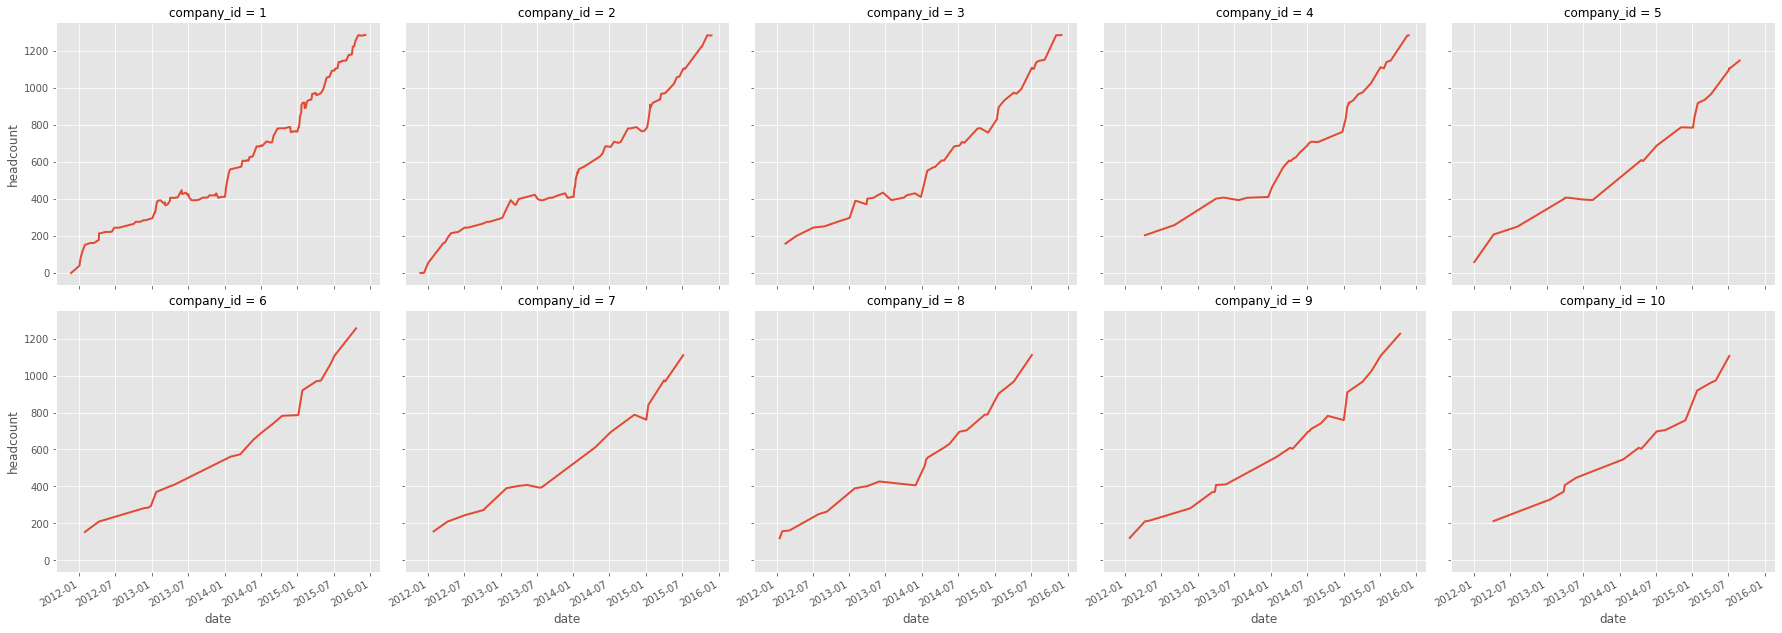

In [20]:
# visualize 
g = sns.relplot(x = 'date', y = 'headcount', col = 'company_id', col_wrap = 5, linewidth = 2,
                kind = 'line', data = headcount)

g.fig.autofmt_xdate()

### Understand Employee Retention: Feature Engineering 

* Check employment length distribution 

* Check week/day of year of quit dates to understand possible seasonality patterns 

* Check those who quit early and see what's related to it most


In [22]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [55]:
# employment length 
# convert timedelta data to int days
data['employment_length'] = (data['quit_date'] - data['join_date']).dt.days
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0


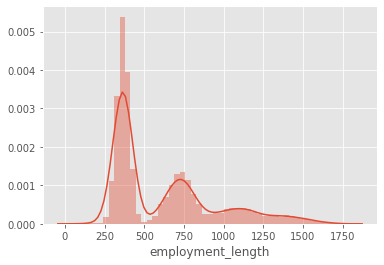

In [58]:
# distribution 
sns.distplot(data['employment_length'].dropna())

#### Peaks happen around each work anniversary. 

In [60]:
data['week_of_a_year'] = data['quit_date'].dt.week
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,week_of_a_year
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,44.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,14.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,23.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0


In [97]:
g = data.groupby('week_of_a_year')['dept'].count()
g.head()

week_of_a_year
1.0    238
2.0    243
3.0    276
4.0    255
5.0    259
Name: dept, dtype: int64

In [77]:
g.values

array([238, 243, 276, 255, 259, 251, 214, 231, 265, 274, 244, 238, 209,
       199, 363, 153, 346, 274, 285, 256, 242, 262, 258, 253, 246, 278,
        89, 400, 270, 252, 284, 262, 261, 260, 276, 236, 270, 275, 265,
       248, 300, 279, 307, 293, 310, 277, 313, 289, 292, 185, 193, 212])

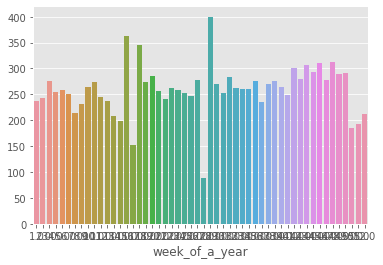

In [95]:
sns.barplot(x = g.index, y = g.values, orient = 'v')


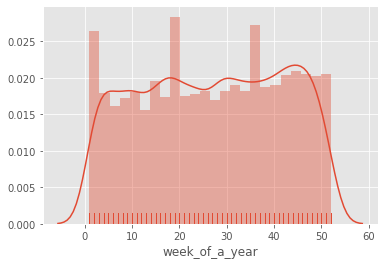

In [65]:
sns.distplot(data['week_of_a_year'].dropna(), hist = True, rug = True)

In [103]:
### Check why people quit early 
data['early_quitters'] = (((data['quit_date'] - data['join_date']).dt.days) <= 396 ) * 1
# data['early_quitters'] = data['early_quitters'].astype('category')
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,week_of_a_year,early_quitters
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,44.0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,14.0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,NaN,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,23.0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0,0


In [111]:
data['dept'], _ = pd.factorize(data['dept'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 10 columns):
employee_id          24702 non-null float64
company_id           24702 non-null int64
dept                 24702 non-null int64
seniority            24702 non-null int64
salary               24702 non-null float64
join_date            24702 non-null datetime64[ns]
quit_date            13510 non-null datetime64[ns]
employment_length    13510 non-null float64
week_of_a_year       13510 non-null float64
early_quitters       24702 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 1.9 MB


In [116]:
# decison tree
tree_clf = DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(data[['company_id', 'dept', 'seniority', 'salary']], data['early_quitters'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

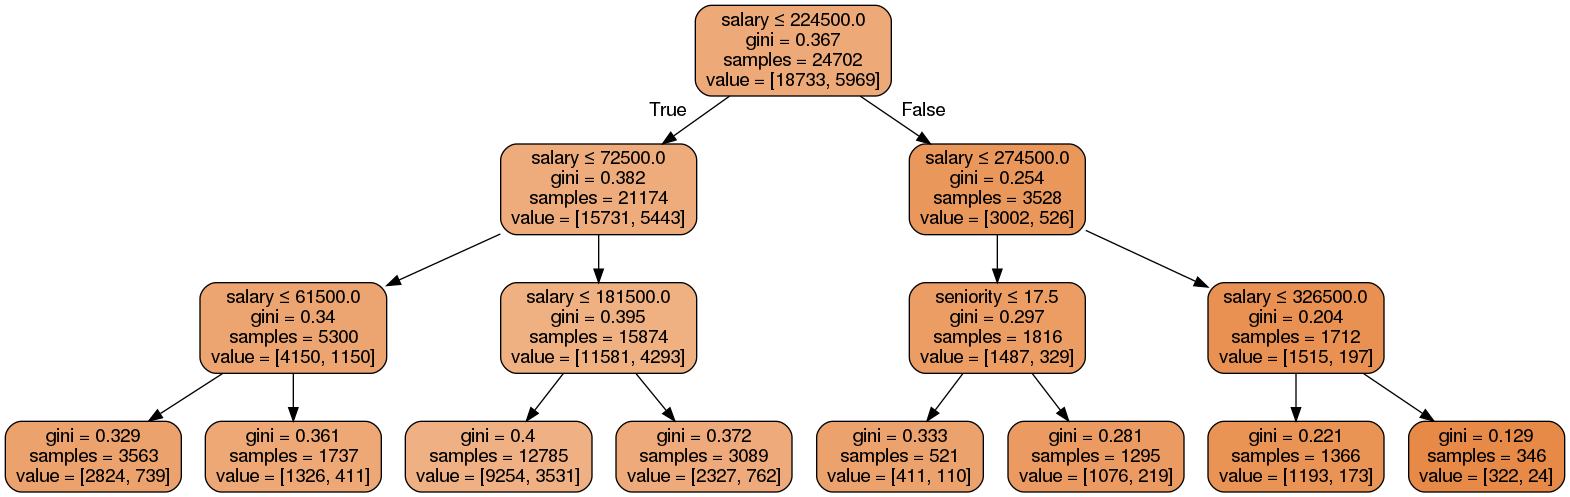

In [117]:
# ! dot -Tsvg abtest.dot -o abtest.svg
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
retention_tree = StringIO()
export_graphviz(tree_clf, out_file=retention_tree,  
                feature_names = ['company_id', 'dept', 'seniority', 'salary'],
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(retention_tree.getvalue())  
Image(graph.create_png())


#### Salary is what matters. 

### Discretize and bin salaries into different groups and check the early quitter percentile in each group

In [188]:
#### cut evenly on salary
min_s = int(min(data['salary'])) - 1
max_s = int(max(data['salary'])) + 1
step = int((max_s - min_s) / 50)
min_s
step

7820

In [189]:
data['salary_pct'] = pd.cut(data['salary'], list(range(min_s, max_s, step)))
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,week_of_a_year,early_quitters,salary_pct
0,13021.0,7,0,28,89000.0,2014-03-24,2015-10-30,585.0,44.0,0,"(87379, 95199]"
1,825355.0,7,1,20,183000.0,2013-04-29,2014-04-04,340.0,14.0,1,"(181219, 189039]"
2,927315.0,4,1,14,101000.0,2014-10-13,NaT,NaN,NaN,0,"(95199, 103019]"
3,662910.0,7,0,20,115000.0,2012-05-14,2013-06-07,389.0,23.0,1,"(110839, 118659]"
4,256971.0,2,2,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0,0,"(275059, 282879]"


In [190]:
g = data.groupby('salary_pct')['early_quitters'].sum()
g.head()

salary_pct
(16999, 24819]     83
(24819, 32639]    163
(32639, 40459]     98
(40459, 48279]    113
(48279, 56099]    148
Name: early_quitters, dtype: int64

In [191]:
total_count = pd.value_counts(data['salary_pct'])
total_count.head()

(63919, 71739]      1253
(95199, 103019]     1202
(71739, 79559]      1142
(87379, 95199]      1120
(110839, 118659]    1118
Name: salary_pct, dtype: int64

In [192]:
percentile = g / total_count
percentile.head()

(16999, 24819]    0.198565
(24819, 32639]    0.207116
(32639, 40459]    0.211207
(40459, 48279]    0.220703
(48279, 56099]    0.209929
dtype: float64

In [193]:
percentile.index = range(1, len(percentile.index) + 1)
percentile.head()

1    0.198565
2    0.207116
3    0.211207
4    0.220703
5    0.209929
dtype: float64

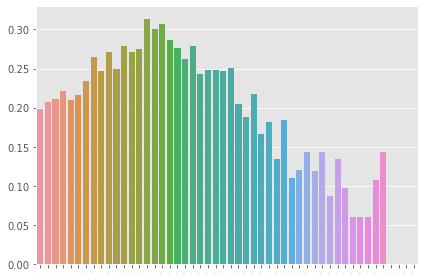

In [194]:
ax = sns.barplot(x = percentile.index, y = percentile.values)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 1)
plt.tight_layout()
plt.show()

In [205]:
#### Cut by quantile 
data['salary_pct'] = pd.qcut(data['salary'], 50)
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,week_of_a_year,early_quitters,salary_pct
0,13021.0,7,0,28,89000.0,2014-03-24,2015-10-30,585.0,44.0,0,"(84000.0, 89000.0]"
1,825355.0,7,1,20,183000.0,2013-04-29,2014-04-04,340.0,14.0,1,"(178000.0, 184000.0]"
2,927315.0,4,1,14,101000.0,2014-10-13,NaT,NaN,NaN,0,"(99000.0, 102000.0]"
3,662910.0,7,0,20,115000.0,2012-05-14,2013-06-07,389.0,23.0,1,"(112000.0, 115000.0]"
4,256971.0,2,2,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0,0,"(266000.0, 283000.0]"


In [206]:
g = data.groupby('salary_pct')['early_quitters'].sum()
g.head()

salary_pct
(16999.999, 25000.0]    109
(25000.0, 30000.0]      102
(30000.0, 37000.0]      104
(37000.0, 45000.0]      100
(45000.0, 52000.0]       95
Name: early_quitters, dtype: int64

In [211]:
total_count = pd.value_counts(data['salary_pct'])
total_count.sort_index(inplace = True)
total_count.head()

(16999.999, 25000.0]    531
(25000.0, 30000.0]      500
(30000.0, 37000.0]      462
(37000.0, 45000.0]      506
(45000.0, 52000.0]      473
Name: salary_pct, dtype: int64

In [215]:
total = pd.merge(g, total_count, left_index = True, right_index = True)
total['percentile'] = total['early_quitters'] / total['salary_pct']
total.index = range(1, len(total) + 1)
total.head()

,early_quitters,salary_pct,percentile
1,109,531,0.205273
2,102,500,0.204000
3,104,462,0.225108
4,100,506,0.197628
5,95,473,0.200846


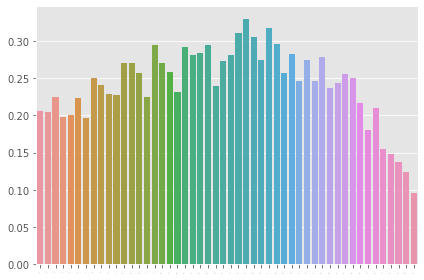

In [216]:
ax = sns.barplot(x = total.index, y = total['percentile'].values)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 1)
plt.tight_layout()
plt.show()

#### People with higher or lower salaries are less likely to leave.